# Data Wrangling WeRateDog

## Table of Contents

- [Introduction](#intro)
- [Gathering data](#gather)
- [Assessing data](#assess)
- [Cleaning data](#clean)
- [Storing](#store)
- [Analyzing and visualizing of wrangled data](#analyze)
- Reporting on 
    - data wrangling efforts and 
    - data analyses and visualizations


<a id='intro'></a>
## Introduction
Real-world data rarely comes clean. 
The goal of this project is to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.

In [104]:
import pandas as pd
import numpy as np
import requests
import re
import os
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from IPython.display import HTML, display

<a id='gather'></a>
## Step 1 : Gathering Data

Gather data from 3 different sources.
-  WeRateDogs Twitter archive 
     - Download file `twitter_archive_enhanced.csv` manually from link provided, given to Udacity from @WeRateDogs
- The tweet image predictions 
    - This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
- Twitter API
    - Query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file
    

Importing  files required programmatically. 

**Enhanced Twitter Archive**

The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." 

In [105]:
# Read csv file
df_twitter_archive = pd.read_csv("twitter-archive-enhanced-2.csv")
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


**Image Predictions File**

One more cool thing: I ran every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs*. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

In [106]:
# Download image predictions from Udacity's server
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
 
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
# Read TSV file  
df_image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**Additional Data via the Twitter API**

Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Well, "anyone" who has access to data for the 3000 most recent tweets, at least. But you, because you have the WeRateDogs Twitter archive and specifically the tweet IDs within it, can gather this data for all 5000+. And guess what? You're going to query Twitter's API to gather this valuable data.

Read the JSON data from the txt file, and rename column tweet id, retweet count and favorite count.

In [107]:
# import data captured via twitter API (see 'twitter_data_fetch.ipynb')
# Create a dataframe with tweet ID, retweet count, and favorite count
# Having problem creating tweeter account. So I am using the supported file from udacity.

df_list = []
with open('tweet_json.txt') as file:
    for line in file:
        tweet = json.loads(line)
        
        df_list.append({
            'tweet_id': tweet['id'],
            'retweet_count': tweet['retweet_count'],
            'favorite_count': tweet['favorite_count']
        })
        
# Create a dataframe with tweet ID, retweet count, and favorite count
df_tweet = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
df_tweet.head()


,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


<a id='assess'></a>
## Step 2 : Data Assess

After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues.

Detect and document at least `eight (8) quality issues` and `two (2) tidiness issues `

### Visual assessment

In [108]:
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [109]:
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [110]:
df_tweet

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


### Programmatic assessment

In [111]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [112]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [113]:
print("This testing period is between {} to {}.".format(df_twitter_archive['timestamp'].min(), df_twitter_archive['timestamp'].max()))

This testing period is between 2015-11-15 22:32:08 +0000 to 2017-08-01 16:23:56 +0000.


In [114]:
# Investigate whether there are missing values in the dataset
print(" Any missing values in df_twitter_archive ?  {}.".format(df_twitter_archive.isnull().values.any()))

 Any missing values in df_twitter_archive ?  True.


In [115]:
# Investigate count of missing values in the dataset
pd.isnull(df_twitter_archive).sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [116]:
print("The number of unique tweet_id in the dataset is {}.".format(int(df_twitter_archive['tweet_id'].nunique())))

The number of unique tweet_id in the dataset is 2356.


In [117]:
#Investigate dog name
df_twitter_archive.groupby('name')['name'].nunique()

name
Abby            1
Ace             1
Acro            1
Adele           1
Aiden           1
               ..
such            1
the             1
this            1
unacceptable    1
very            1
Name: name, Length: 957, dtype: int64

In [118]:
 df_twitter_archive[df_twitter_archive['expanded_urls'].duplicated()].count()

tweet_id                      137
in_reply_to_status_id          54
in_reply_to_user_id            54
timestamp                     137
source                        137
text                          137
retweeted_status_id             1
retweeted_status_user_id        1
retweeted_status_timestamp      1
expanded_urls                  79
rating_numerator              137
rating_denominator            137
name                          137
doggo                         137
floofer                       137
pupper                        137
puppo                         137
dtype: int64

In [119]:
df_twitter_archive['expanded_urls'].value_counts()

https://twitter.com/dog_rates/status/786963064373534720/photo/1                                                                                                                 2
https://twitter.com/dog_rates/status/683391852557561860/photo/1                                                                                                                 2
https://twitter.com/dog_rates/status/681694085539872773/photo/1                                                                                                                 2
https://twitter.com/dog_rates/status/740676976021798912/photo/1                                                                                                                 2
https://twitter.com/dog_rates/status/694669722378485760/photo/1,https://twitter.com/dog_rates/status/694669722378485760/photo/1                                                 2
                                                                                                              

From 'expanded url' column, 137 tweets are repetitive. When count of this column, i found that some expanded URLs had two.

In [120]:
df_twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [121]:
print(df_twitter_archive.loc[df_twitter_archive.rating_numerator == 60, 'text']) 

1351    Here is a whole flock of puppers.  60/50 I'll ...
Name: text, dtype: object


In [122]:
print(df_twitter_archive.loc[df_twitter_archive.rating_numerator == 420, 'text']) 
print(df_twitter_archive.loc[df_twitter_archive.rating_numerator == 143, 'text']) 
print(df_twitter_archive.loc[df_twitter_archive.rating_numerator == 666, 'text']) 
print(df_twitter_archive.loc[df_twitter_archive.rating_numerator == 1176, 'text'])
print(df_twitter_archive.loc[df_twitter_archive.rating_numerator == 182, 'text'])
print(df_twitter_archive.loc[df_twitter_archive.rating_numerator == 960, 'text'])

188     @dhmontgomery We also gave snoop dogg a 420/10...
2074    After so many requests... here you go.\n\nGood...
Name: text, dtype: object
1634    Two sneaky puppers were not initially seen, mo...
Name: text, dtype: object
189    @s8n You tried very hard to portray this good ...
Name: text, dtype: object
Series([], Name: text, dtype: object)
290    @markhoppus 182/10
Name: text, dtype: object
313    @jonnysun @Lin_Manuel ok jomny I know you're e...
Name: text, dtype: object


In [123]:
print(df_twitter_archive['text'][1634])

Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3


In [124]:
df_twitter_archive['rating_denominator'].unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2], dtype=int64)

In [125]:
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [126]:
print(df_twitter_archive.loc[df_twitter_archive.rating_denominator == 11, 'text']) 
print(df_twitter_archive.loc[df_twitter_archive.rating_denominator == 2, 'text']) 
print(df_twitter_archive.loc[df_twitter_archive.rating_denominator == 16, 'text']) 
print(df_twitter_archive.loc[df_twitter_archive.rating_denominator == 15, 'text'])
print(df_twitter_archive.loc[df_twitter_archive.rating_denominator == 7, 'text'])
print(df_twitter_archive.loc[df_twitter_archive.rating_denominator == 0, 'text'])
print(df_twitter_archive.loc[df_twitter_archive.rating_denominator == 170, 'text'])

784     RT @dog_rates: After so many requests, this is...
1068    After so many requests, this is Bretagne. She ...
1662    This is Darrel. He just robbed a 7/11 and is i...
Name: text, dtype: object
2335    This is an Albanian 3 1/2 legged  Episcopalian...
Name: text, dtype: object
1663    I'm aware that I could've said 20/16, but here...
Name: text, dtype: object
342    @docmisterio account started on 11/15/15
Name: text, dtype: object
516    Meet Sam. She smiles 24/7 &amp; secretly aspir...
Name: text, dtype: object
313    @jonnysun @Lin_Manuel ok jomny I know you're e...
Name: text, dtype: object
1120    Say hello to this unbelievably well behaved sq...
Name: text, dtype: object


In [127]:
print(df_twitter_archive['text'][784])
print(df_twitter_archive['text'][1068])
print(df_twitter_archive['text'][1662])
print(df_twitter_archive['text'][2335])
print(df_twitter_archive['text'][1663])
print(df_twitter_archive['text'][342])
print(df_twitter_archive['text'][516])
print(df_twitter_archive['text'][313])
print(df_twitter_archive['text'][1120])

RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible
@docmisterio account started on 11/15/15
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 

In [128]:
with pd.option_context('max_colwidth', 200):
    display(df_twitter_archive[df_twitter_archive['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


In [129]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [130]:
print(" Any missing values in df_image_predictions ?  {}.".format(df_image_predictions.isnull().values.any()))

 Any missing values in df_image_predictions ?  False.


In [131]:
sum(df_image_predictions['tweet_id'].duplicated())

0

In [132]:
sum(df_image_predictions.jpg_url.duplicated())

66

In [133]:
df_image_predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [134]:
#  first prediction = 'p1'
df_image_predictions['p1'].value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
dhole                   1
zebra                   1
panpipe                 1
bib                     1
sea_urchin              1
Name: p1, Length: 378, dtype: int64

In [135]:
df_image_predictions['p2'].value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
wallaby                 1
chain_mail              1
lighter                 1
dining_table            1
toaster                 1
Name: p2, Length: 405, dtype: int64

In [136]:
df_image_predictions['p3'].value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
pot                    1
axolotl                1
marmot                 1
greenhouse             1
jersey                 1
Name: p3, Length: 408, dtype: int64

In [137]:
# Find rows where p1, p2, p3 are all false (first line of code is the count)

df_image_predictions[(df_image_predictions['p1_dog']==False) & (df_image_predictions['p2_dog']==False) & (df_image_predictions['p3_dog']==False)].count()

tweet_id    324
jpg_url     324
img_num     324
p1          324
p1_conf     324
p1_dog      324
p2          324
p2_conf     324
p2_dog      324
p3          324
p3_conf     324
p3_dog      324
dtype: int64

In [138]:
df_image_predictions[(df_image_predictions['p1_dog']==False) & (df_image_predictions['p2_dog']==False) & (df_image_predictions['p3_dog']==False)].sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
260,670783437142401025,https://pbs.twimg.com/media/CU8Z-OxXAAA-sd2.jpg,1,lacewing,0.381955,False,sulphur_butterfly,0.106810,False,leafhopper,0.068347,False
1210,742465774154047488,https://pbs.twimg.com/media/Ck3EribXEAAPhZn.jpg,1,web_site,0.997154,False,comic_book,0.000439,False,desktop_computer,0.000268,False
217,670069087419133954,https://pbs.twimg.com/media/CUyQRzHWoAAhF1D.jpg,1,boathouse,0.313829,False,birdhouse,0.138331,False,ashcan,0.045673,False
974,706901761596989440,https://pbs.twimg.com/media/Cc9rZlBWwAA56Ra.jpg,1,wild_boar,0.859499,False,hog,0.128981,False,warthog,0.011318,False
1572,795076730285391872,https://pbs.twimg.com/media/CwiuEJmW8AAZnit.jpg,2,gas_pump,0.676439,False,harvester,0.049995,False,swing,0.044660,False
537,676948236477857792,https://pbs.twimg.com/media/CWUA1GFW4AAowiq.jpg,1,guenon,0.611603,False,macaque,0.135176,False,squirrel_monkey,0.083247,False
152,668645506898350081,https://pbs.twimg.com/media/CUeBiqgXAAARLbj.jpg,1,ski_mask,0.302854,False,knee_pad,0.096881,False,balance_beam,0.084076,False
655,682242692827447297,https://pbs.twimg.com/media/CXfQG_fW8AAjVhV.jpg,1,snorkel,0.504983,False,loggerhead,0.345298,False,scuba_diver,0.074754,False
1322,756526248105566208,https://pbs.twimg.com/media/Cn-4m2CXYAErPGe.jpg,1,geyser,0.991273,False,volcano,0.004673,False,fountain,0.001234,False
1357,760641137271070720,https://pbs.twimg.com/media/Co5XExUWgAAL5L_.jpg,1,axolotl,0.132695,False,killer_whale,0.131113,False,sea_lion,0.069652,False


In [139]:
df_tweet.info()       
df_tweet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [140]:
# Make sure all id's are unique - no duplicates
print(sum(df_tweet.groupby('tweet_id')['tweet_id'].nunique())) 
# sum of unique values
print(sum(df_tweet.tweet_id.duplicated())) # Sum of duplicates

2354
0


In [141]:
df_tweet.sort_values(['favorite_count'], ascending=False)

,tweet_id,retweet_count,favorite_count
412,822872901745569793,48265,132810
1037,744234799360020481,79515,131075
65,879415818425184262,45849,107956
533,807106840509214720,56625,107015
134,866450705531457537,32883,106827
...,...,...,...
883,760153949710192640,38,0
478,815745968457060357,4797,0
475,816014286006976512,6154,0
474,816062466425819140,1207,0


### Assessment Observations

**Quality - Completeness, validity, accuracy, consistency (content issues)**

`df_twitter_archive`

1) wrong datatype for some columns eg : timestamp should be datetime instead of objec (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be integers/strings instead of float.)

2) There are 181 retweet entries. We only want Use only original ratings tweets, not retweets.

3) Rating denominator and numerators value are inconsistent or incorrect. 
  - Generally, the denominators are 10 or multiple of 10. But there are other denominator needed to be readjust or removed.
  - However, rating numerators that are greater than the denominators does not need to be cleaned. 
      This unique rating system is a big part of the popularity of WeRateDogs.

4) Wrong numerators and denominators are captured from text 

 - some are actually refer to date or other meaning 15/8 and 24/7.
 - wrongly captured due to decimal and spaces "11. 26/10" was captured as "26/10"
 
5) Tweets that has no image.

`df_image_predictions`

6) Inconsistent capitalization on predicted dog names

7) There are 324 rows non dog image (where p1, p2, and p3 are false)

8) duplicated jpg urls with different tweet ids

9) 'None' string should be replaced with 'NaN'

10) All 3 files contain different number of rows.

**Tidiness**

1) 2 columns storing rating information.

2) 4 columns (doggo, floofer, pupper, puppo) to indicate dog stages.

3) All 3 files contain common tweet_id column, which can be used to join all three files as one dataframe.



<a id='clean'></a>
## Step 3 : Cleaning data

Here we will fix the quality and tidiness issues that we identified in step 2.

Cleaning process involves three steps:

Define :  convert assessments into defined cleaning tasks. These definitions also serve as an instruction list so others (in the future) can look at the work and reproduce it.

Code :  convert those definitions to code and run that code.

Test :  test dataset, visually or with code, to make sure cleaning operations worked.

#### Create the copies of the dataframes which will be cleaned


In [142]:
df_twitter_archive_clean = df_twitter_archive.copy() 
df_image_predictions_clean = df_image_predictions.copy() 
df_tweet_clean = df_tweet.copy()

In [143]:
print(len(df_twitter_archive_clean))
print(len(df_image_predictions_clean))
print(len(df_tweet_clean))


2356
2075
2354


**1) Remove Tweets that are retweeted. Keep original.**
    
Define : Remove tweets that are retweeted because these tweets are not orginal. There are 181 retweeted.

Code : 

In [144]:
df_twitter_archive_clean = df_twitter_archive_clean[pd.isnull(df_twitter_archive_clean.retweeted_status_id)]

Test : 

In [145]:
#Test
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

**2) Remove Tweets with no image or duplicated image**

Define : Drop Tweets where expanded_urls = null or duplicated

Code : 

In [146]:
#Without pictures:
df_twitter_archive_clean = df_twitter_archive_clean.dropna(subset=['expanded_urls'])

# duplicated:
df_twitter_archive_clean = df_twitter_archive_clean.drop_duplicates(subset=['expanded_urls'], keep='last')

Test:

In [147]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2116 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2116 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2116 non-null   object 
 4   source                      2116 non-null   object 
 5   text                        2116 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2116 non-null   object 
 10  rating_numerator            2116 non-null   int64  
 11  rating_denominator          2116 non-null   int64  
 12  name                        2116 non-null   object 
 13  doggo                       2116 

**3) Remove duplicated images.**

Define : Drop 66 jpg_url duplicated.

Code : 

In [148]:
#Delete duplicated jpg_url
df_image_predictions_clean = df_image_predictions_clean.drop_duplicates(subset=['jpg_url'], keep='last')

In [149]:
Test : 

SyntaxError: invalid syntax (<ipython-input-149-8c4690d83a7a>, line 1)

In [150]:
sum(df_image_predictions_clean['jpg_url'].duplicated())

0

**4) All 3 files contain common tweet_id column, which can be used to join all three files as one dataframe.**

Define : Merge df_tweet_clean and df_image_predictions_clean into df_twitter_archive_clean

Code : 

In [151]:
df_twitter_archive_clean = pd.merge(left=df_twitter_archive_clean,
                                 right=df_tweet_clean, left_on='tweet_id', right_on='tweet_id', how='inner')

In [152]:
df_twitter_archive_clean = df_twitter_archive_clean.merge(df_image_predictions_clean, on='tweet_id', how='inner')

Test : 

In [153]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 1927
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1928 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   1928 non-null   object 
 4   source                      1928 non-null   object 
 5   text                        1928 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1928 non-null   object 
 10  rating_numerator            1928 non-null   int64  
 11  rating_denominator          1928 non-null   int64  
 12  name                        1928 non-null   object 
 13  doggo                       1928 

**5) 4 columns (doggo, floofer, pupper, puppo) to indicate dog stages.**

Define : Move doggo, floofer, pupper and puppo columns into one column dog_stage.

Code : 

In [154]:
#Some dogs has multiple stages, will concatenate them.

df_twitter_archive_clean.loc[df_twitter_archive_clean.doggo == 'None', 'doggo'] = ''
df_twitter_archive_clean.loc[df_twitter_archive_clean.floofer == 'None', 'floofer'] = ''
df_twitter_archive_clean.loc[df_twitter_archive_clean.pupper == 'None', 'pupper'] = ''
df_twitter_archive_clean.loc[df_twitter_archive_clean.puppo == 'None', 'puppo'] = ''

df_twitter_archive_clean.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,,,,,1633
1,,,,puppo,21
2,,,pupper,,199
3,,floofer,,,7
4,doggo,,,,59
5,doggo,,,puppo,1
6,doggo,,pupper,,7
7,doggo,floofer,,,1


In [155]:
df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean.doggo + df_twitter_archive_clean.floofer + df_twitter_archive_clean.pupper + df_twitter_archive_clean.puppo
df_twitter_archive_clean.loc[df_twitter_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo,pupper'
df_twitter_archive_clean.loc[df_twitter_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo,puppo'
df_twitter_archive_clean.loc[df_twitter_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo,floofer'

df_twitter_archive_clean.loc[df_twitter_archive_clean.dog_stage == '', 'dog_stage'] = 'None'

Test : 

In [156]:
df_twitter_archive_clean.dog_stage.value_counts()

None             1633
pupper            199
doggo              59
puppo              21
floofer             7
doggo,pupper        7
doggo,puppo         1
doggo,floofer       1
Name: dog_stage, dtype: int64

**6) Remove Used columns**

Define :  : Delete columns that we will not use them or benefit from them.

Code :

In [157]:
#Useless columns:
df_twitter_archive_clean = df_twitter_archive_clean.drop(['retweeted_status_user_id',
                              'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id'], axis=1)


#Duplicates in dog_stage:
df_twitter_archive_clean = df_twitter_archive_clean.sort_values('dog_stage').drop_duplicates('tweet_id', keep = 'last')

Test : 

In [158]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 292
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tweet_id             1928 non-null   int64  
 1   timestamp            1928 non-null   object 
 2   source               1928 non-null   object 
 3   text                 1928 non-null   object 
 4   retweeted_status_id  0 non-null      float64
 5   expanded_urls        1928 non-null   object 
 6   rating_numerator     1928 non-null   int64  
 7   rating_denominator   1928 non-null   int64  
 8   name                 1928 non-null   object 
 9   doggo                1928 non-null   object 
 10  floofer              1928 non-null   object 
 11  pupper               1928 non-null   object 
 12  puppo                1928 non-null   object 
 13  retweet_count        1928 non-null   int64  
 14  favorite_count       1928 non-null   int64  
 15  jpg_url              1928 non-null   ob

**7)  Incorrected datatypes**

Define:
'timestamp' should be converted to a datetime object.

Code : 

In [159]:
#remove time zone information and convert 'timestamp' to a datatime obeject
 
df_twitter_archive_clean['timestamp'] = pd.to_datetime(df_twitter_archive_clean['timestamp'], format = "%Y-%m-%d %H:%M:%S")

**8) Inconsistent cases in predicted dog names**
    
Define : Change predicted dog names to lower case
        
Code :

In [160]:
#Change predicted dog names to lower case
df_twitter_archive_clean['p1'] = df_twitter_archive_clean['p1'].str.lower()
df_twitter_archive_clean['p2'] = df_twitter_archive_clean['p2'].str.lower()
df_twitter_archive_clean['p3'] = df_twitter_archive_clean['p3'].str.lower()

Test : 

In [161]:
df_twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,doggo,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
344,815639385530101762,2017-01-01 19:22:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Titan. His nose is quite chilly. Reque...,NaN,https://twitter.com/dog_rates/status/815639385...,12,10,Titan,,...,german_shepherd,0.817953,True,norwegian_elkhound,0.140007,True,malinois,0.024821,True,None
1507,674255168825880576,2015-12-08 15:52:13+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bobbay. He's a marshmallow wizard...,NaN,https://twitter.com/dog_rates/status/674255168...,10,10,Bobbay,,...,eskimo_dog,0.615741,True,siberian_husky,0.199544,True,malamute,0.179107,True,None
1419,676470639084101634,2015-12-14 18:35:43+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Three generations of pupper. 11/10 for all htt...,NaN,https://twitter.com/dog_rates/status/676470639...,11,10,None,,...,golden_retriever,0.790386,True,borzoi,0.022885,True,dingo,0.015343,False,pupper
714,746906459439529985,2016-06-26 03:22:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,,...,traffic_light,0.470708,False,fountain,0.199776,False,space_shuttle,0.064807,False,None
1555,673240798075449344,2015-12-05 20:41:29+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Magical floating dog here. Very calm. Always h...,NaN,https://twitter.com/dog_rates/status/673240798...,6,10,None,,...,airedale,0.443004,True,brown_bear,0.114162,False,chesapeake_bay_retriever,0.094639,True,None


**9) Incorrect numerator or denominator**

- There are some ratings which are not rating.
- Rating denominator is not consistent.

Define :
-  Readjust or remove rating_numerator values are much higher than the rating_denominator.
 - Update both numerators and denominators when necessary. 
 - Delete other five tweets because they do not have actual ratings.
 - Remove outlier where numerator/denominator = 420/10 , 1776/10  
 - The rating_denominator should be fixed to 10 or multiple of 10. 

Code : 


In [162]:
 #fix wrong value , eg : 11. 26/10 was taken as 26/10
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 740373189193256964), 'rating_numerator'] = 14
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 740373189193256964), 'rating_denominator'] = 10

df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 682962037429899265), 'rating_numerator'] = 10
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 682962037429899265), 'rating_denominator'] = 10

df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 666287406224695296), 'rating_numerator'] = 9
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 666287406224695296), 'rating_denominator'] = 10

df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 722974582966214656), 'rating_numerator'] = 13
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 722974582966214656), 'rating_denominator'] = 10

df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 716439118184652801), 'rating_numerator'] = 13.5
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 716439118184652801), 'rating_denominator'] = 10

#eg : 11. 26/10 was taken as 26/10
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 786709082849828864), 'rating_numerator'] = 9.5
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 680494726643068929), 'rating_numerator'] = 11.25
df_twitter_archive_clean.loc[(df_twitter_archive_clean.tweet_id == 778027034220126208), 'rating_numerator'] = 11.25


#Delete five tweets with no actual ratings
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['tweet_id'] != 832088576586297345]
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['tweet_id'] != 810984652412424192]
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['tweet_id'] != 682808988178739200]
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['tweet_id'] != 835246439529840640]
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['tweet_id'] != 686035780142297088]


# Delete outlier
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['rating_numerator'] != 420]
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['rating_numerator'] != 1776]
 

Test : 

In [163]:
with pd.option_context('max_colwidth', 200):
    display(df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator'] != 10][['tweet_id',
                                                                                      'text',
                                                                                      'rating_numerator',
                                                                                      'rating_denominator']])

,tweet_id,text,rating_numerator,rating_denominator
1248,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110
1247,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143.0,130
1436,675853064436391936,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,88.0,80
1377,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144.0,120
1003,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50
920,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80
898,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90
938,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50
1077,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0,40
316,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70


**10)  Rating_numberator and rating_denominator can be converted into one column**

Define:
Rating_numberator and rating_denominator can be converted to float because some values has decimals. Also, Create new rating column where denomintor is 10 for all tweets

Code:

In [164]:
df_twitter_archive_clean['rating_numerator'] = df_twitter_archive_clean['rating_numerator'].astype(int)
df_twitter_archive_clean['rating_denominator'] = df_twitter_archive_clean['rating_denominator'].astype(float)

In [165]:
df_twitter_archive_clean['rating'] = 10 * df_twitter_archive_clean['rating_numerator'] / df_twitter_archive_clean['rating_denominator']

Test : 

In [166]:
with pd.option_context('max_colwidth', 200):
    display(df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator'] != 10][['tweet_id',
                                                                                      'text',
                                                                                      'rating_numerator',
                                                                                      'rating_denominator',
                                                                                           'rating']])

,tweet_id,text,rating_numerator,rating_denominator,rating
1248,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110.0,11.0
1247,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143,130.0,11.0
1436,675853064436391936,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,88,80.0,11.0
1377,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144,120.0,12.0
1003,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50.0,12.0
920,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80.0,10.0
898,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90.0,11.0
938,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50.0,9.0
1077,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44,40.0,11.0
316,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70.0,12.0


In [167]:
df_twitter_archive_clean['rating'].value_counts()

12.0    435
10.0    413
11.0    388
13.0    243
9.0     153
8.0      95
7.0      51
14.0     33
5.0      33
6.0      32
3.0      19
4.0      15
2.0       9
1.0       4
0.0       2
Name: rating, dtype: int64

In [168]:
#df_twitter_archive_clean.query('rating == 1776')['text'] 
#print(df_twitter_archive_clean['text'][684])
#df2.query('converted == 1 and landing_page == "new_page"')['user_id']
#df_twitter_archive_clean.query('rating == 420')['text'] 
#print(df_twitter_archive_clean['text'][1655])
#df_twitter_archive_clean.query('rating == 27')['tweet_id'] 
#print(df_twitter_archive_clean['text'][521])
#df_twitter_archive_clean.query('rating == 26')['tweet_id'] 
#print(df_twitter_archive_clean['text'][1319])


Series([], Name: tweet_id, dtype: int64)

In [169]:
df_twitter_archive_clean['rating'].value_counts()

12.0    435
10.0    413
11.0    388
13.0    243
9.0     153
8.0      95
7.0      51
14.0     33
5.0      33
6.0      32
3.0      19
4.0      15
2.0       9
1.0       4
0.0       2
Name: rating, dtype: int64

<a id='store'></a>
## Step 4 : Store Data

Save the gathered, assessed, and cleaned master dataset to a CSV file.

In [170]:
#Save the gathered, assessed, and cleaned master dataset to a CSV file.
df_twitter_archive_clean.to_csv('twitter_archive_master.csv')

<a id='analyze'></a>
## Step 5 : Analyze Data

In [171]:
df_master = pd.read_csv('twitter_archive_master.csv')
df_master.head()

,Unnamed: 0,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
0,0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,https://twitter.com/dog_rates/status/892420643...,13,10.0,Phineas,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None,13.0
1,1273,682962037429899265,2016-01-01 16:30:13+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,NaN,https://twitter.com/dog_rates/status/682962037...,10,10.0,Darrel,...,0.278600,False,chihuahua,0.155207,True,loupe,0.153598,False,None,10.0
2,1272,683030066213818368,2016-01-01 21:00:32+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Lulu. She's contemplating all her unre...,NaN,https://twitter.com/dog_rates/status/683030066...,10,10.0,Lulu,...,0.722218,True,bull_mastiff,0.193804,True,french_bulldog,0.055194,True,None,10.0
3,1270,683098815881154561,2016-01-02 01:33:43+00:00,"<a href=""http://twitter.com/download/iphone"" r...",aahhhhkslaldhwnxmzbbs 12/10 for being da smoos...,NaN,https://twitter.com/dog_rates/status/683098815...,12,10.0,None,...,0.889848,True,kuvasz,0.053008,True,labrador_retriever,0.037881,True,None,12.0
4,1267,683357973142474752,2016-01-02 18:43:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...","""Have a seat, son. There are some things we ne...",NaN,https://twitter.com/dog_rates/status/683357973...,10,10.0,None,...,0.406509,True,cardigan,0.154854,True,siberian_husky,0.136366,True,None,10.0


In [172]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1925 non-null   int64  
 1   tweet_id             1925 non-null   int64  
 2   timestamp            1925 non-null   object 
 3   source               1925 non-null   object 
 4   text                 1925 non-null   object 
 5   retweeted_status_id  0 non-null      float64
 6   expanded_urls        1925 non-null   object 
 7   rating_numerator     1925 non-null   int64  
 8   rating_denominator   1925 non-null   float64
 9   name                 1925 non-null   object 
 10  doggo                68 non-null     object 
 11  floofer              8 non-null      object 
 12  pupper               206 non-null    object 
 13  puppo                22 non-null     object 
 14  retweet_count        1925 non-null   int64  
 15  favorite_count       1925 non-null   i

**Insight 1: Most commonly predicted breeds**

- The most commonly predicted dog breeds is golden retriever.

Text(0, 0.5, 'Breeds')

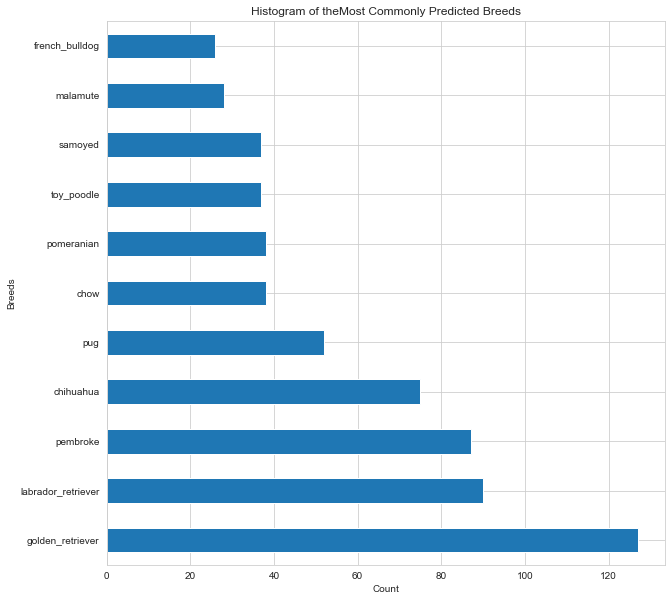

In [173]:
df_dog = df_master.groupby('p1').filter(lambda x: len(x) >= 25)

g_common_predicted_breeds = df_dog['p1'].value_counts().plot(kind = 'barh', figsize=(10,10))
plt.title('Histogram of theMost Commonly Predicted Breeds')
plt.xlabel('Count')
plt.ylabel('Breeds')

**Insight 2 :  Most Tweeted Dog Stages**
- Pupper is having highest tweets among other dog stage.

In [174]:
dog_stages_count = df_master['dog_stage'].value_counts()

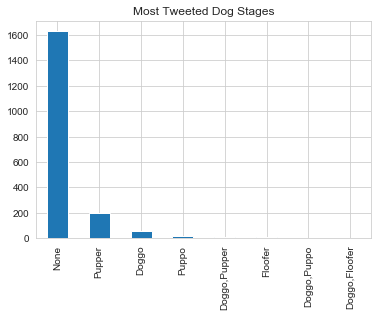

In [175]:
x = np.arange(8)
g = dog_stages_count.plot(kind = 'bar', title = 'Most Tweeted Dog Stages')
plt.xticks(x, ('None', 'Pupper', 'Doggo', 'Puppo', 'Doggo,Pupper', 'Floofer', 'Doggo,Puppo', 'Doggo,Floofer'));

**Insight 3 :  Correlation between Retweet Count and Favorite Count.**

There is a positive correlation between favorites and retweeting.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


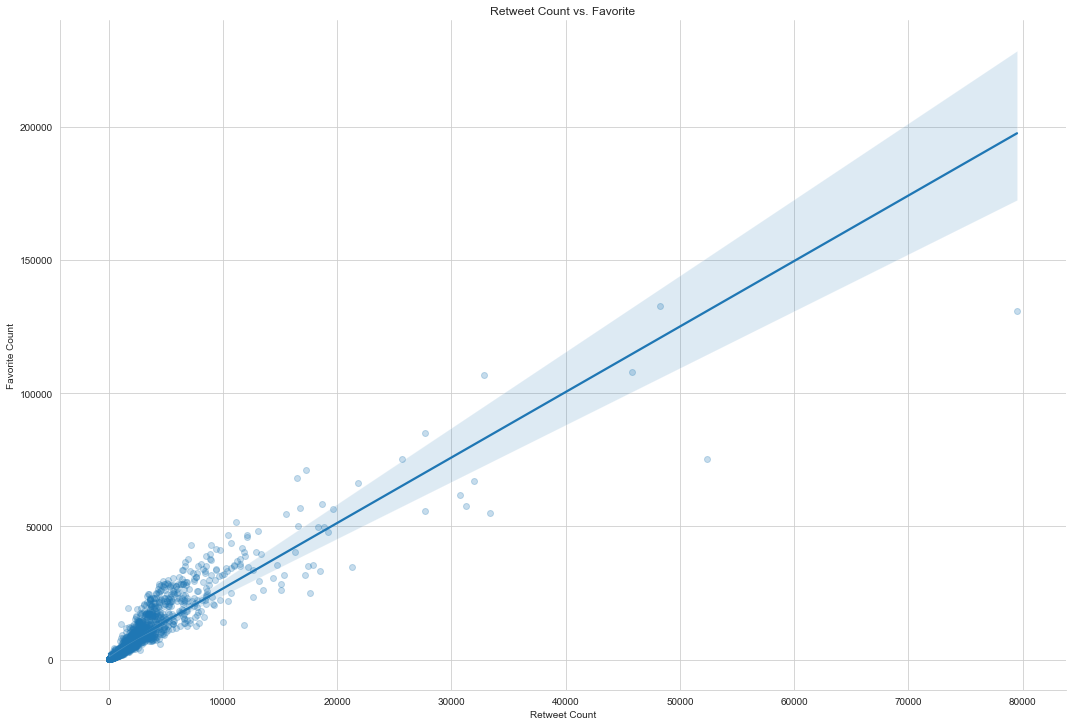

In [176]:
g_retweet_fav = sns.lmplot(x = 'retweet_count', y = 'favorite_count', data = df_master, size = 10, aspect = 1.5, scatter_kws={'alpha':1/4})
plt.title('Retweet Count vs. Favorite')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count');

# Exporting the figure

g_retweet_fav.savefig('correlation_retweet_fav.png')

**Insight 4 : Rating VS frequency VS total retweet**

In [177]:
df_master['rating'].value_counts()
frequency = df_master['rating'].value_counts().to_dict()
f = pd.DataFrame(list(frequency.items()), columns=['rating', 'frequency'])
f.head()

,rating,frequency
0,12.0,435
1,10.0,413
2,11.0,388
3,13.0,243
4,9.0,153


In [178]:
# Calculating the totals for Retweet
total_retweet =[]
for i in f['rating']:
    t_r = df_master[df_master['rating'] == i]['retweet_count'].sum()
    total_retweet.append(t_r)

f['total_retweet']=total_retweet
f.head()
**Insight 5 : The highest ratings do not receive the most retweets.**
# Calculating the mean for Retweets
f['retweet_mean']=f['total_retweet']//f['frequency']
f.head()

SyntaxError: invalid syntax (<ipython-input-178-74387125f924>, line 9)

**Insight 5 : The highest ratings do not receive the most retweets.**

In [ ]:
g = df_master.plot(x='rating', y='retweet_count', kind='scatter')

plt.xlabel('Rating')
plt.ylabel('Retweet Counts')
plt.title('Retweet Counts by Ratings Scatter Plot')
 
# Exporting the figure
fig =g.get_figure()
fig.savefig('rating_and_retweets.png')

## Addtional :

Reader may also refer to wrangle report(wrangle_report.pdf) and action report (act_report.pdf).